In [68]:
import numpy as np
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [69]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Limit the dataset to the first 30000 samples for both training and testing
num_samples = 30000
X_train, y_train = X_train[:num_samples], y_train[:num_samples]
X_test, y_test = X_test[:num_samples], y_test[:num_samples]

# Reshape and normalize the data
X_train = X_train.reshape(-1, 784).astype(np.float32) / 255
X_test = X_test.reshape(-1, 784).astype(np.float32) / 255

# One-hot encode the labels
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_one_hot = encoder.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = encoder.transform(y_test[:, np.newaxis])

# Print shapes and types for verification
print("y_train shape:", y_train.shape)
print("y_train_one_hot shape:", y_train_one_hot.shape)
print("y_train_one_hot dtype:", y_train_one_hot.dtype)

y_train shape: (30000,)
y_train_one_hot shape: (30000, 10)
y_train_one_hot dtype: float64


In [70]:
# Split the training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=42)

# Print shapes for verification
print("X_train_split shape:", X_train_split.shape)
print("X_val shape:", X_val.shape)
print("y_train_split shape:", y_train_split.shape)
print("y_val shape:", y_val.shape)

X_train_split shape: (24000, 784)
X_val shape: (6000, 784)
y_train_split shape: (24000, 10)
y_val shape: (6000, 10)


In [71]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=20)
for mini_X_train, mini_y_train in get_mini_batch:
    mini_X_train, mini_y_train
mini_X_train = mini_X_train.reshape(20, 1, 28, 28)

In [72]:
class SimpleInitializer:

    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def W(self,f_num, Chanel, f_size_h, f_size_w):
        np.random.seed(0)
        self.W = self.sigma * np.random.randn(f_num, Chanel, f_size_h, f_size_w)
        return self.W

    def B(self, f_num):
        np.random.seed(0)
        self.B = self.sigma * np.random.randn(f_num,1)
        return self.B

class XavierInitializer:

    def __init__(self, sigma = 0.01):
        self.sigma = sigma

    def W(self,f_num, Chanel, f_size_h, f_size_w):
        self.sigma = (1 / np.sqrt(f_num))
        np.random.seed(0)
        self.W = self.sigma * np.random.randn(f_num, Chanel, f_size_h, f_size_w)
        return self.W

    def B(self,f_num):
        np.random.seed(0)
        self.sigma = (1 / np.sqrt(f_num))
        self.B = self.sigma * np.random.randn(f_num,1)
        return self.B

class He:

    def __init__(self, sigma = 0.01):
        self.sigma = sigma

    def W(self, f_num, Chanel, f_size_h, f_size_w):
        sigma = np.sqrt(2 / 1)
        np.random.seed(0)
        self.W = sigma * np.random.randn(f_num, Chanel, f_size_h, f_size_w)
        return self.W

    def B(self,f_num):
        sigma = np.sqrt(2 / 1)
        np.random.seed(0)
        self.B = sigma * np.random.randn(f_num,1)
        return self.B

class SGD:

    def __init__(self, lr=0.001):
        self.lr = lr

    def update(self,layer):

        layer.W -= (self.lr * layer.dW)
        layer.B -= (self.lr * layer.dB)
        return layer.W, layer.B

In [73]:
def output_height_calculation(X_h,pad_n,F_h,stride):
    output_h = (X_h + 2*pad_n - F_h)//stride + 1
    return output_h

In [74]:
def output_width_calculation(X_w,pad_n,F_w,stride):
    output_w = (X_w + 2*pad_n - F_w)//stride + 1
    return output_w

In [75]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = output_height_calculation(X_h=H,pad_n=pad, F_h=filter_h, stride=stride)
    out_w = output_width_calculation(X_w=W,pad_n=pad, F_w=filter_w, stride=stride)
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [76]:
def col2im(col, X, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = X.shape
    out_h = output_height_calculation(X_h=H,pad_n=pad, F_h=filter_h, stride=stride)
    out_w = output_width_calculation(X_w=W,pad_n=pad, F_w=filter_w, stride=stride)
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## Problem One: Creating a 2-D convolutional layer

In [77]:
class SimpleConv2d:

    def __init__(self, f_num=1, f_size_h=2, f_size_w=2, stride=1, pad = 1, initializer=XavierInitializer(), optimizer=SGD(lr=0.05)):

        self.f_num = f_num
        self.f_size_h = f_size_h
        self.f_size_w = f_size_w
        self.pad = pad
        self.stride = stride
        self.kernel  = None
        self.initializer = initializer
        self.optimizer = optimizer
        self.W = None
        self.B = None

    def im2col(self, input_data):
        N, C, H, W = input_data.shape
        out_h = output_height_calculation(X_h=H,pad_n=self.pad, F_h= self.f_size_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W,pad_n=self.pad, F_w=self.f_size_w, stride=self.stride)
        img = np.pad(input_data, [(0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        col = np.zeros((N, C, self.f_size_h, self.f_size_w, out_h, out_w))

        for y in range(self.f_size_h):
            y_max = y + self.stride*out_h
            for x in range(self.f_size_w):
                x_max = x + self.stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col

    def col2im(self, col, X):
        N, C, H, W = X.shape
        out_h = output_height_calculation(X_h=H,pad_n=self.pad, F_h=self.f_size_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W,pad_n=self.pad, F_w=self.f_size_w, stride=self.stride)
        col = col.reshape(N, out_h, out_w, C, self.f_size_h, self.f_size_w).transpose(0, 3, 4, 5, 1, 2)
        img = np.zeros((N, C, H + 2*self.pad + self.stride - 1, W + 2*self.pad + self.stride - 1))

        for y in range(self.f_size_h):
            y_max = y + self.stride*out_h
            for x in range(self.f_size_w):
                x_max = x + self.stride*out_w
                img[:, :, y:y_max:self.stride, x:x_max:self.stride] += col[:, :, y, x, :, :]
        return img[:, :, self.pad:H + self.pad, self.pad:W + self.pad]

    def forward(self,X):
        if self.W is None:
            self.W = self.initializer.W(self.f_num, X.shape[1], self.f_size_h , self.f_size_w)
        if self.B is None:
            self.B = self.initializer.B(self.f_num)
        FN, C, FH, FW = self.W.shape
        N, C, H, W = X.shape
        out_h = output_height_calculation(X_h=H,pad_n=self.pad, F_h=self.f_size_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W,pad_n=self.pad, F_w=self.f_size_w, stride=self.stride)

        self.col = self.im2col(X)
        self.col_W = self.W.reshape(FN, -1).T
        out = np.dot(self.col, self.col_W) + self.B.T
        out = out.reshape(N, out_h, out_w, -1).transpose(0,3,1,2)
        self.X = X
        return out

    def backward(self,dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        self.dB = np.sum(dout, axis=0).reshape(self.f_num,1)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        self.dx = self.col2im(dcol,self.X)

        return self.dx
        self = self.optimizer.update(self)

In [78]:
model_test = SimpleConv2d(f_num=3, f_size_h=3,  f_size_w=3, stride=1, pad=1, initializer=SimpleInitializer())

## Problem Two:Experiment of 2D convolvolation layer in small array

In [79]:
conv_output = model_test.forward(mini_X_train)

In [80]:
model_test.backward(conv_output)

array([[[[1.25967230e-03, 1.01337586e-03, 1.01337586e-03, ...,
          1.01337586e-03, 1.01337586e-03, 1.65385372e-04],
         [1.55351675e-03, 1.28528097e-03, 1.28528097e-03, ...,
          1.28528097e-03, 1.28528097e-03, 3.41881849e-05],
         [1.55351675e-03, 1.28528097e-03, 1.28528097e-03, ...,
          1.28528097e-03, 1.28528097e-03, 3.41881849e-05],
         ...,
         [1.55351675e-03, 1.28528097e-03, 1.28528097e-03, ...,
          1.28528097e-03, 1.28528097e-03, 3.41881849e-05],
         [1.55351675e-03, 1.28528097e-03, 1.28528097e-03, ...,
          1.28528097e-03, 1.28528097e-03, 3.41881849e-05],
         [1.20249692e-03, 9.53283644e-04, 9.53283644e-04, ...,
          9.53283644e-04, 9.53283644e-04, 6.04504498e-05]]],


       [[[1.25967230e-03, 1.01337586e-03, 1.01337586e-03, ...,
          1.01337586e-03, 1.01337586e-03, 1.65385372e-04],
         [1.55351675e-03, 1.28528097e-03, 1.28528097e-03, ...,
          1.28528097e-03, 1.28528097e-03, 3.41881849e-05],
      

## Problem Three: Output size after 2-dimensional convolution

In [81]:
model_test.backward(conv_output).shape

(20, 1, 28, 28)

## Problem Four: Creation of maximum pooling layer

In [82]:
class MaxPool2D:

    def __init__(self, P_h, P_w, stride=1, pad=0):
        self.P_h = P_h
        self.P_w = P_w
        self.stride = stride
        self.pad = pad
        self.x = None
        self.arg_max = None

    def im2col(self, input_data):
        N, C, H, W = input_data.shape
        out_h = output_height_calculation(X_h=H,pad_n=self.pad, F_h= self.P_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W,pad_n=self.pad, F_w=self.P_w, stride=self.stride)
        img = np.pad(input_data, [(0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        col = np.zeros((N, C, self.P_h, self.P_w, out_h, out_w))

        for y in range(self.P_h):
            y_max = y + self.stride*out_h
            for x in range(self.P_w):
                x_max = x + self.stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col

    def col2im(self, col, X):
        N, C, H, W = X.shape
        out_h = output_height_calculation(X_h=H,pad_n=self.pad, F_h=self.P_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W,pad_n=self.pad, F_w=self.P_w, stride=self.stride)
        col = col.reshape(N, out_h, out_w, C, self.P_h, self.P_w).transpose(0, 3, 4, 5, 1, 2)
        img = np.zeros((N, C, H + 2*self.pad + self.stride - 1, W + 2*self.pad + self.stride - 1))

        for y in range(self.P_h):
            y_max = y + self.stride*out_h
            for x in range(self.P_w):
                x_max = x + self.stride*out_w
                img[:, :, y:y_max:self.stride, x:x_max:self.stride] += col[:, :, y, x, :, :]
        return img[:, :, self.pad:H + self.pad, self.pad:W + self.pad]

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = output_height_calculation(X_h=H,pad_n=self.pad, F_h=self.P_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W,pad_n=self.pad, F_w=self.P_w, stride=self.stride)
        col = self.im2col(x)
        col = col.reshape(-1, self.P_h*self.P_w)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        self.x = x
        self.arg_max = arg_max
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        p_size = self.P_h * self.P_w
        dmax = np.zeros((dout.size, p_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (p_size,))
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self.col2im(dcol, self.x)
        return dx
        self = self.optimizer.update(self)

In [83]:
max_pool = MaxPool2D( P_h=2, P_w=2, stride=2, pad=0)
pool_output = max_pool.forward(conv_output)
pool_backward_output = max_pool.backward(pool_output)

In [84]:
pool_output.shape

(20, 3, 14, 14)

In [85]:
pool_backward_output.shape

(20, 3, 28, 28)

## Problem Five: (Advance task) Creating average pooling

In [86]:
class AveragePool2D:
    def __init__(self, P_h, P_w, stride=1, pad=0):
        self.P_h = P_h
        self.P_w = P_w
        self.stride = stride
        self.pad = pad
        self.x = None

    def im2col(self, input_data):
        N, C, H, W = input_data.shape
        out_h = output_height_calculation(X_h=H, pad_n=self.pad, F_h=self.P_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W, pad_n=self.pad, F_w=self.P_w, stride=self.stride)
        img = np.pad(input_data, [(0, 0), (0, 0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        col = np.zeros((N, C, self.P_h, self.P_w, out_h, out_w))

        for y in range(self.P_h):
            y_max = y + self.stride * out_h
            for x in range(self.P_w):
                x_max = x + self.stride * out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
        return col

    def col2im(self, col, X):
        N, C, H, W = X.shape
        out_h = output_height_calculation(X_h=H, pad_n=self.pad, F_h=self.P_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W, pad_n=self.pad, F_w=self.P_w, stride=self.stride)
        col = col.reshape(N, out_h, out_w, C, self.P_h, self.P_w).transpose(0, 3, 4, 5, 1, 2)
        img = np.zeros((N, C, H + 2 * self.pad + self.stride - 1, W + 2 * self.pad + self.stride - 1))

        for y in range(self.P_h):
            y_max = y + self.stride * out_h
            for x in range(self.P_w):
                x_max = x + self.stride * out_w
                img[:, :, y:y_max:self.stride, x:x_max:self.stride] += col[:, :, y, x, :, :]
        return img[:, :, self.pad:H + self.pad, self.pad:W + self.pad]

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = output_height_calculation(X_h=H, pad_n=self.pad, F_h=self.P_h, stride=self.stride)
        out_w = output_width_calculation(X_w=W, pad_n=self.pad, F_w=self.P_w, stride=self.stride)
        col = self.im2col(x)
        col = col.reshape(-1, self.P_h * self.P_w)
        out = np.mean(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        self.x = x
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.P_h * self.P_w
        dcol = np.ones((dout.size, pool_size)) / pool_size
        dcol = dcol.reshape(dout.shape + (pool_size,))
        dcol = dcol.reshape(dcol.shape[0] * dcol.shape[1] * dcol.shape[2], -1)
        dx = self.col2im(dcol, self.x)
        return dx

def output_height_calculation(X_h, pad_n, F_h, stride):
    return (X_h + 2 * pad_n - F_h) // stride + 1

def output_width_calculation(X_w, pad_n, F_w, stride):
    return (X_w + 2 * pad_n - F_w) // stride + 1


# Example input for testing
np.random.seed(0)
mini_X_train = np.random.randn(2, 3, 8, 8)  # (N, C, H, W)

# Initialize and test AveragePool2D
average_pool = AveragePool2D(P_h=2, P_w=2, stride=2, pad=0)

# Forward pass
pool_output = average_pool.forward(mini_X_train)
print("Average Pool Forward output shape:", pool_output.shape)

# Backward pass (for testing gradients)
dout = np.random.randn(*pool_output.shape)  # Random gradient for testing
pool_backward_output = average_pool.backward(dout)
print("Average Pool Backward output shape:", pool_backward_output.shape)

Average Pool Forward output shape: (2, 3, 4, 4)
Average Pool Backward output shape: (2, 3, 8, 8)


## Problem Six: Smoothing

In [87]:
class Flatten:

    def forward(self, x):
        N, C, H, W = x.shape
        out = x.reshape(N, -1)
        self.x = x
        return out

    def backward(self, dout):
        dx = dout.reshape(self.x.shape)
        return dx

In [88]:
# Initialize the Flatten layer
flatten_layer = Flatten()

# Forward pass through the Flatten layer
flattened_output = flatten_layer.forward(conv_output)

# Backward pass through the Flatten layer
gradient_from_flatten = flatten_layer.backward(flattened_output)

# Print shapes to verify the results
print(f'Initial Convolution Output Shape: {conv_output.shape}')
print(f'Flattened Output Shape: {flattened_output.shape}')
print(f'Gradient from Backward Pass Shape: {gradient_from_flatten.shape}')

Initial Convolution Output Shape: (20, 3, 28, 28)
Flattened Output Shape: (20, 2352)
Gradient from Backward Pass Shape: (20, 3, 28, 28)


In [89]:
class FC:

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        self.optimizer = optimizer
        self.HW = 0
        self.HB = 0

    def forward(self, X):
        self.Z = X
        self.A = X @ self.W + self.B
        return self.A

    def backward(self, dA):
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA
        self.dZ = dA @ self.W.T
        self = self.optimizer.update(self)
        return self.dZ

class SoftmaxWithLoss:

    def forward(self, A):
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return Z

    def backward(self, Z, y):
        dA = Z - y
        loss = - np.sum(y * np.log(Z)) / len(y)
        return dA, loss

class AdaGrad:

    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.HW += layer.dW * layer.dW
        layer.HB += layer.dB * layer.dB
        delta = 1e-7
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.HW) + delta) / len(layer.Z)
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.HB) + delta) / len(layer.Z)
        return layer

class HeInitializer:

    def __init__(self, sigma):
        _ = sigma

    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

class Relu:

    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        return Z

    def backward(self, dZ):
        dA = dZ * np.where(self.A > 0, 1, 0)
        return dA

In [90]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)
    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [91]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [92]:
class MaxPool2D2:

    def __init__(self, P_h, P_w, pad=0):
        self.P_h = P_h
        self.P_w = P_w
        self.stride = P_h
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.P_h) / self.stride)
        out_w = int(1 + (W - self.P_w) / self.stride)
        col = im2col(x, self.P_h, self.P_w, self.stride, self.pad)
        col = col.reshape(-1, self.P_h*self.P_w)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        self.x = x
        self.arg_max = arg_max
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.P_h * self.P_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.P_h, self.P_w, self.stride, self.pad)
        return dx

In [93]:
class Scratch2dCNNClassifier:

    def __init__(self, FN=20, FH=7, FW=7, stride=1, pad=0, epoch=1, optimizer=AdaGrad, initializer=HeInitializer, activater=Relu, verbose=False,):
        self.verbose = verbose
        self.batch_size = 60
        self.n_output = 10
        self.sigma = 0.02
        self.lr = 0.05
        self.epoch = epoch
        self.optimizer = optimizer
        self.initializer = initializer
        self.activater = activater
        self.FN = FN
        self.C = 1
        self.FH = FH
        self.FW = FW
        self.pool_h = 2
        self.pool_w = 2
        self.pad = pad
        self.stride = stride

    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_train = []
        self.loss_val = []
        out_h, out_w = self.out_size(28, 28, self.pad, self.FH, self.FW, self.stride)
        out_h, out_w = self.out_size(out_h, out_w, 0, self.pool_h, self.pool_w, self.pool_h)
        fc_nodes = self.FN * out_h * out_w
        optimizer = self.optimizer(self.lr)
        w = self.sigma * np.random.randn(self.FN, self.C, self.FH, self.FW)
        b = self.sigma * np.random.randn(self.FN,)
        self.cv= SimpleConv2d(self.FN, self.FH, self.FW, self.stride, self.pad, initializer=SimpleInitializer())
        self.activation_cv = self.activater()
        self.pl = MaxPool2D2(self.pool_h, self.pool_w)
        self.fl = Flatten()
        self.FC = FC(fc_nodes, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation_fc = SoftmaxWithLoss()

        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            for mini_X, mini_y in get_mini_batch:

                A1 = self.cv.forward(mini_X)
                Z1 = self.activation_cv.forward(A1)
                P1 = self.pl.forward(Z1)
                F1 = self.fl.forward(P1)
                A2 = self.FC.forward(F1)
                Z2 = self.activation_fc.forward(A2)

                dA2, loss = self.activation_fc.backward(Z2, mini_y)
                dZ2 = self.FC.backward(dA2)
                dF1 = self.fl.backward(dZ2)
                dP1 = self.pl.backward(dF1)
                dA1 = self.activation_cv.backward(dP1)
                dZ1 = self.cv.backward(dA1)

            if self.verbose:
                A1 = self.cv.forward(X)
                Z1 = self.activation_cv.forward(A1)
                P1 = self.pl.forward(Z1)
                F1 = self.fl.forward(P1)
                A2 = self.FC.forward(F1)
                Z2 = self.activation_fc.forward(A2)
                self.loss_train.append(self.activation_fc.backward(Z2, y)[1])

                if X_val is not None:
                    A1 = self.cv.forward(X_val)
                    Z1 = self.activation_cv.forward(A1)
                    P1 = self.pl.forward(Z1)
                    F1 = self.fl.forward(P1)
                    A2 = self.FC.forward(F1)
                    Z2 = self.activation_fc.forward(A2)
                    self.loss_val.append(self.activation_fc.backward(Z2, y_val)[1])

    def out_size(self, H, W, P, FH, FW, S):
        out_h = (H + 2 * P - FH) // S + 1
        out_w = (W + 2 * P - FW) // S + 1
        return out_h, out_w

    def predict(self, X):
        A1 = self.cv.forward(X)
        Z1 = self.activation_cv.forward(A1)
        P1 = self.pl.forward(Z1)
        F1 = self.fl.forward(P1)
        A2 = self.FC.forward(F1)
        Z2 = self.activation_fc.forward(A2)
        return np.argmax(Z2, axis=1)

In [94]:
(X_train2, y_train2), (X_test2, y_test2) = mnist.load_data()

X_train2 = X_train2[0:100,:]
y_train2 = y_train2[0:100]
X_test2 = X_test2[0:100,:]
y_test2 = y_test2[0:100]

X_train2 = X_train2.astype(float)
X_test2 = X_test2.astype(float)
X_train2 /= 255
X_test2 /= 255

X_train2 = X_train2[:, np.newaxis, :, :]
X_test2 = X_test2[:, np.newaxis, :, :]

X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.2)

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_one_hot2 = enc.fit_transform(y_train2[:, np.newaxis])
y_test_one_hot2 = enc.transform(y_val2[:, np.newaxis])

## Problem Seven: Learning and Estimation

In [95]:
S2dCNN = Scratch2dCNNClassifier(FN=5, FH=7, FW=7, stride=1, pad=3, epoch =10, verbose=True)
S2dCNN.fit(X_train2, y_train_one_hot2, X_val2, y_test_one_hot2)

In [96]:
pred = S2dCNN.predict(X_val2)
accuracy_score(y_val2, pred)

0.1

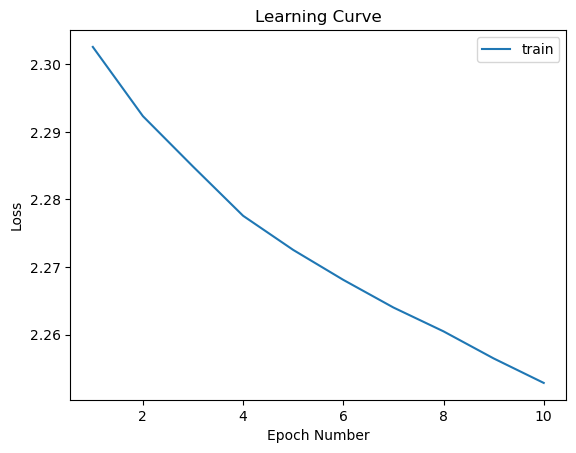

In [97]:
plt.title('Learning Curve')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(list(range(1, S2dCNN.epoch+1)), S2dCNN.loss_train, label='train')
plt.legend()

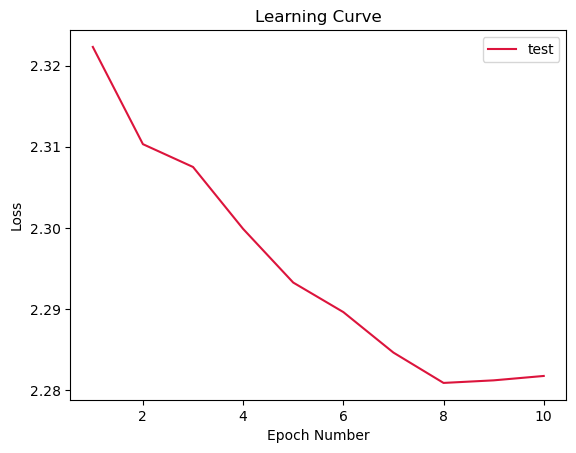

In [98]:
plt.title('Learning Curve')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(list(range(1, S2dCNN.epoch+1)), S2dCNN.loss_val, label='test', color='crimson')
plt.legend()

## Problem Nine: (Advance assignment) Survey of famous image recognition models

##### **AlexNet (2012)**
AlexNet revolutionized image recognition by introducing deeper networks and leveraging GPU acceleration. Its architecture features a series of convolutional layers followed by fully connected layers, using ReLU activations to speed up training and dropout to combat overfitting. It was one of the first models to effectively handle large-scale image data and laid the groundwork for modern CNNs.

##### **VGG16 (2014)**
VGG16 is known for its simplicity and depth. It relies on small 3x3 convolutional filters stacked in a straightforward manner, along with max pooling layers. This design focuses on deepening the network with uniformity and has become a popular choice for feature extraction due to its well-defined hierarchical structure.

##### **ResNet (2015)**
ResNet introduced the idea of residual learning with shortcut connections, allowing networks to be extremely deep without suffering from vanishing gradients. By bypassing certain layers, it facilitates the training of very deep models and has greatly influenced how modern neural networks are designed.

These models each contributed uniquely to the field of image recognition, influencing how we approach deep learning and design complex neural networks.

## Problem Ten: Calculation of output size and number of parameters

To calculate the output size and the number of parameters for each convolutional layer, we can follow these formulas:

##### Output Size Calculation

The output size of a convolutional layer is given by:

$$
\text{Output Size} = \frac{\text{Input Size} - \text{Filter Size} + 2 \times \text{Padding}}{\text{Stride}} + 1
$$

For layers with no padding (`Padding = 0`), the formula simplifies to:

$$
\text{Output Size} = \frac{\text{Input Size} - \text{Filter Size}}{\text{Stride}} + 1
$$

##### Number of Parameters Calculation

The number of parameters for a convolutional layer includes:

1. **Weights**: Each filter has a size of $(\text{Filter Height} \times \text{Filter Width} \times \text{Number of Input Channels})$, and there are N filters.
2. **Biases**: There is one bias per filter.

So the total number of parameters is:

$$
\text{Number of Parameters} = (\text{Filter Height} \times \text{Filter Width} \times \text{Number of Input Channels} + 1) \times \text{Number of Filters}
$$

Let's compute these for each case:

##### **1. Convolutional Layer**

- **Input Size**: 144x144, 3 channels
- **Filter Size**: 3x3, 6 channels
- **Stride**: 1
- **Padding**: None (0)

**Output Size Calculation**:

$$
\text{Output Size} = \frac{144 - 3}{1} + 1 = 142
$$

So the output size is $142 \times 142$.

**Number of Parameters Calculation**:

$$
\text{Number of Parameters} = (3 \times 3 \times 3 + 1) \times 6 = (27 + 1) \times 6 = 28 \times 6 = 168
$$

##### **2. Convolutional Layer**

- **Input Size**: 60x60, 24 channels
- **Filter Size**: 3x3, 48 channels
- **Stride**: 1
- **Padding**: None (0)

**Output Size Calculation**:

$$
\text{Output Size} = \frac{60 - 3}{1} + 1 = 58
$$

So the output size is $58 \times 58$.

**Number of Parameters Calculation**:

$$
\text{Number of Parameters} = (3 \times 3 \times 24 + 1) \times 48 = (216 + 1) \times 48 = 217 \times 48 = 10,416
$$

##### **3. Convolutional Layer**

- **Input Size**: 20x20, 10 channels
- **Filter Size**: 3x3, 20 channels
- **Stride**: 2
- **Padding**: None (0)

**Output Size Calculation**:

$$
\text{Output Size} = \frac{20 - 3}{2} + 1 = \frac{17}{2} + 1 = 8.5 + 1 = 9.5
$$

Since the output size must be an integer, the framework may use the floor function. Thus, the output size is approximately $9 \times 9$.

**Number of Parameters Calculation**:

$$
\text{Number of Parameters} = (3 \times 3 \times 10 + 1) \times 20 = (90 + 1) \times 20 = 91 \times 20 = 1,820
$$

##### Summary:

1. **First Layer**:
   - Output Size: $142 \times 142$
   - Number of Parameters: 168

2. **Second Layer**:
   - Output Size: $58 \times 58$
   - Number of Parameters: 10,416

3. **Third Layer**:
   - Output Size: $9 \times 9$ (rounded from 9.5)
   - Number of Parameters: 1,820


## Problem Eleven: (Advance assignment) Survey on filter size

### Why 3×3 Filters Are Commonly Used

1. **Effective Receptive Field**: Using multiple 3×3 filters stacked together can cover a larger receptive field while maintaining computational efficiency. For instance, two 3×3 convolutional layers in sequence can cover the same receptive field as a single 5×5 filter, but with fewer parameters.

2. **Reduced Number of Parameters**: A $3 \times 3$ filter has fewer parameters compared to a larger filter like $7 \times 7$. This reduces the computational burden and helps prevent overfitting. For example, a single $3 \times 3$ filter has $3 \times 3 = 9$ weights, whereas a $7 \times 7$ filter has $7 \times 7 = 49$ weights.

3. **Non-Linearity and Hierarchical Feature Extraction**: Stacking multiple 3×3 layers allows the network to learn hierarchical features. Each 3×3 layer can learn different types of features, and deeper layers can combine these features to detect more complex patterns.

4. **Computational Efficiency**: Smaller filters, like 3×3, lead to fewer computations compared to larger filters. This helps speed up training and inference, making the model more practical for real-world applications.

5. **Empirical Success**: The effectiveness of 3×3 filters has been demonstrated in several successful architectures like VGG and ResNet. This empirical success reinforces their popularity and effectiveness.

### Effect of a 1×1 Filter

1. **Dimensionality Reduction**: A 1×1 filter is often used to reduce the number of channels (depth) of the input feature map. It performs a linear transformation on each pixel independently. For instance, if you have an input with 256 channels, applying a 1×1 filter with 64 filters will reduce the channel depth to 64 while retaining the spatial dimensions.

2. **Computational Efficiency**: 1×1 convolutions are computationally less expensive than larger filters. They can be used to adjust the depth of feature maps efficiently without affecting the spatial dimensions.

3. **Feature Combination**: A 1×1 convolution can be seen as a way to mix features across channels. It allows the network to learn new features by combining existing ones. This can be useful for capturing relationships between different channels and creating new feature representations.

4. **Inception Modules**: In architectures like GoogLeNet (Inception modules), 1×1 convolutions are used to combine features from different convolutions (e.g., 3×3 and 5×5) in the same layer. This allows the network to capture a diverse set of features while controlling computational complexity.

**Summary** 3×3 filters are commonly used due to their balance of computational efficiency and the ability to capture local features effectively. On the other hand, 1×1 filters are valuable for reducing dimensionality, feature combination, and computational efficiency.